# This program is to add the VAE into the pipeline
# it uses the globally trained VAE on APOGEE
# it uses an initial cut of >20 control stars between RHM and RT
# it uses N/sigma2 to identify control clusters
# it uses N (ctrl) to identify field clusters

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

# VAE
import pandas as pd
from AST425_kin import *
from AST425 import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

# Using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [118]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt2 = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')


### drop all NaN kinematic and chemistry values
apogee_nofilt = apogee_nofilt2.dropna(subset=['FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
apogee_nofilt = apogee_nofilt.reset_index(drop=True)
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

In [29]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov and i <= ra + fov and df['DEC'].values[count] >= dec - fov and df['DEC'].values[count] <= dec + fov:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a 10x10 fov of the GC')
    
    '''if len(stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_10RHM/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm')
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title(name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    try:
        plt.savefig('GCs_10RHM/'+name+'/radec.png')
    except:
        print('No stars yo')
    plt.close('all')'''
    
    return stars
            

#### Separating list of stars into lists by parameter

In [30]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [31]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [32]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [33]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    #data_pmfilter = GC_cols.dropna(subset=['GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'VHELIO_AVG', 'VERR'])
    
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [34]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [35]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [36]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

#### Filter 5 for data: Removing all flagged stars

In [37]:
def flag_filter(data_snrfilter):
    aspcapflags_filter = np.array(data_snrfilter[13])==0
    starflags_filter = np.array(data_snrfilter[14])==0
    
    flag_filter = aspcapflags_filter*starflags_filter
    
    data_flagfilter = []
    for i in data_snrfilter:
        a = np.array(i)[flag_filter]
        data_flagfilter.append(a)

    print("There are {} stars in our sample after removing sources with flags.".format(len(data_flagfilter[0])))
    
    return data_flagfilter

#### Master filter function

In [38]:
def master_filter(GC_dict, GC_cols):
    GC_pm_filter = pm_filter(GC_dict, GC_cols)
    GC_abundance_filter = chem_filter(GC_pm_filter, 15)
    GC_duplicates_filter = dup_filter(GC_abundance_filter)
    GC_SNR_filter = SNR_filter(GC_duplicates_filter)
    #GC_flag_filter = flag_filter(GC_SNR_filter)
    
    print('\nThe final amount of stars in our sample is:', len(GC_SNR_filter[0]))
    return GC_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

# update Mar 21: new run with only rhm

In [39]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trhmrt2: {:.2f}\trt: {:.2f}'.format(rhm_deg, (rhm_deg + rt_deg) / 2, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    ### TEST: rhm stars
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + " and {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_6/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_6/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return indices_control

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [40]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pre_nonerr_array = []
    params_arr = []
    
    pre_err_array = []
    
    for key in param_dict:
        if 'err' not in str(key):
            pre_nonerr_array.append(data_filter[param_dict[key]])
            params_arr.append(key)
        else:
            pre_err_array.append(data_filter[param_dict[key]])
    
    pre_nonerr_array = np.array(pre_nonerr_array)
    pre_err_array = np.array(pre_err_array)
    
    standardized = []
    standardized_err = []
    
    for i in pre_nonerr_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    for i in pre_err_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        norm = (i - mean) / sigma
        standardized_err.append(norm)
    
    vae_labels = np.transpose(np.array(standardized))
    vae_err_labels = np.transpose(np.array(standardized_err))
    
    vae_full_labels = np.c_[vae_labels, vae_err_labels]
        
    return [standardized, vae_full_labels]


#### tSNE function

In [41]:
def master_tSNE(data_filter, param_dict, indices_control, name):
    standardized_array = standardize_data(data_filter, param_dict)[0]
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)
    
    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2, perplexity=50)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    tsne_dimX = tsne_2d[:, 0]
    tsne_dimY = tsne_2d[:, 1]

    # Get t-SNE outputs for control group:
    tsne_dimX_control = tsne_dimX[indices_control]
    tsne_dimY_control = tsne_dimY[indices_control]
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(tsne_dimX, tsne_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control , tsne_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16, loc=1)
    #plt.savefig('GCs_20RHMRT_6/'+name+'/tsne.png')
    plt.close('all')
        
    return [tsne_dimX, tsne_dimY, tsne_dimX_control, tsne_dimY_control]

#### UMAP function

In [42]:
def master_UMAP(data_filter, param_dict, indices_control, name):
    standardize = standardize_data(data_filter, param_dict)[0]
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)
    
    # Run umap on the transposed array:
    reducer = umap.UMAP(n_neighbors=50)
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get umap outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get umap outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    #plt.savefig('GCs_20RHMRT_6/'+name+'/umap.png')
    plt.close('all')
    
    return [umap_dimX, umap_dimY, umap_dimX_control, umap_dimY_control]

#### VAE (kin)

In [43]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") 
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            #print(z_mean,z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    final_loss_kin(data, reconstruction) #for custom loss, average over 1 axis, change to custom loss here
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    

def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss
 
def vae_loss(y_true, y_pred, mean, var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss = kl_loss(mean, log_var)
    return  r_loss + kl_loss

In [44]:
def master_vae(data_filter, param_dict, indices_control, name, e, e_weights, d, d_weights):
    vae_labels = standardize_data(data_filter, param_dict)[1]
    
    print(vae_labels[0].size)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)
    
    encoder = keras.models.load_model(e, compile=False) #Loading the encoder model
    decoder = keras.models.load_model(d, compile=False) #Loading the decoder model
    
    vae = VAE(encoder, decoder) 

    #On a given encoder model defined by vae_new we want to load the weights for encoder and decoder
    vae.get_layer(e).load_weights(e_weights) 
    vae.get_layer(d).load_weights(d_weights) 
    vae.compile(optimizer=keras.optimizers.Adam()) #Now we need to compile the model
    
    np.random.seed(2023425) #need this to give same value for sampled position z
    mean, var, z = encoder(vae_labels)
    reconstruction = decoder(z)
    
    vae_dimX = z[:,0]
    vae_dimY = z[:,1]
    
    vae_dimX = vae_dimX.numpy()
    vae_dimY = vae_dimY.numpy()
    #print(vae_dimX.numpy())
    '''print(indices_control)
    print(indices_control[0])'''
    
    vae_dimX_control = vae_dimX[indices_control]
    vae_dimY_control = vae_dimY[indices_control]
    
    vae_x_25, vae_x_75 = np.percentile(vae_dimX, [25,75])
    vae_y_25, vae_y_75 = np.percentile(vae_dimY, [25,75])
    
    iqr_x = vae_x_75 - vae_x_25
    iqr_y = vae_y_75 - vae_y_25
    
    #print(vae_x_25 - 1.5 * iqr_x, vae_x_75 + 1.5 * iqr_x, np.min(vae_dimX), np.max(vae_dimX))
    #print(vae_y_25 - 1.5 * iqr_y, vae_y_75 + 1.5 * iqr_y, np.min(vae_dimY), np.max(vae_dimY))
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(vae_dimX, vae_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(vae_dimX_control, vae_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("VAE X-Dimension", fontsize=16)
    ax.set_ylabel("VAE Y-Dimension", fontsize=16)
    ax.set_xlim(vae_x_25 - 1.5 * iqr_x, vae_x_75 + 1.5 * iqr_x)
    ax.set_ylim(vae_y_25 - 1.5 * iqr_y, vae_y_75 + 1.5 * iqr_y)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    #plt.savefig('GCs_20RHMRT_6/'+name+'/vae.png')
    #plt.show()
    plt.close('all')
    
    return [vae_dimX, vae_dimY, vae_dimX_control, vae_dimY_control]

#### Choosing which parameters to use for tSNE and UMAP

In [45]:
def ask_input_param(param):
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [46]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

#### Taking in datasheet and name and automatically getting the parameters

In [47]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [48]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

### Master function (automatic version)

In [49]:
def master_func_auto(GC_name, master_param_dict, fov, db, dataset, params, ML, e, e_weights, d, d_weights):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg, rt_deg, GC_name)
        
        # no control stars
        #print(GC_indices_control)
        if GC_indices_control[0] is None:
            #print("This shit got no control stars\n")
            return [None, None, None, None, None, None, None, None]
        
        else:
            # choosing parameters
            param_dict = master_param_dict

            if ML == 0:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_name)

                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_name)
                
                # VAEing
                VAE_X, VAE_Y, VAE_control_X, VAE_control_Y = master_vae(GC_filter_data, param_dict, GC_indices_control, GC_name, e, e_weights, d, d_weights)
                
                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, VAE_X, VAE_Y, VAE_control_X, VAE_control_Y, GC_indices_control]

            elif ML == 1:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

            elif ML == 2:
                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control)

                print('Done!\n')
                return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

#### Global GC params

In [50]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR', 'ASPCAPFLAG', 'STARFLAG',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 15 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37,
                  'RV': RV_index, 'RV_err': RV_index + 1,
                  'PMRA': PMRA_index, 'PMRA_err': PMRA_index + 1,
                  'PMDEC': PMDEC_index, 'PMDEC_err': PMDEC_index + 1}

'''all_param_dict = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37}'''


# VAE encoder and decoder file names
encode_kin = 'encoder_kin'
decode_kin = 'decoder_kin'
encode_weights_kin = 'encoder_weights_kin.h5'
decode_weights_kin = 'decoder_weights_kin.h5'

fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

#### Reading in from the GC database

In [51]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_stars_dict = {}

In [52]:
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [84]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_list)):
    GC_stars_dict[i] = master_func_auto(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index, encode_kin, encode_weights_kin, decode_kin, decode_weights_kin)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC
There are 467 stars in our sample after the proper motion filtering.
There are 467 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 467 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 467
rhm: 0.08	rhmrt2: 0.84	rt: 1.61
There are 0 stars within rhm and 137 stars within (rhm+rt)/2 and 185 stars within the rt
Directory NGC_104 already exists
44
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC
There are 287 stars in our sample after the proper motion filtering.
There are 287 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 287 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 287
rhm: 0.05	rhmrt2: 0.33	rt: 0.60
There are 12 stars within rhm and 49 stars within (rhm+rt)/2 and 84 stars within the rt
Directory NGC_288 already exis

44
Done!


Processing: NGC_6273
3054 stars in a 10x10 fov of the GC
There are 3044 stars in our sample after the proper motion filtering.
There are 3044 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3044 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3044
rhm: 0.03	rhmrt2: 0.15	rt: 0.27
There are 6 stars within rhm and 40 stars within (rhm+rt)/2 and 47 stars within the rt
Directory NGC_6273 already exists
44
Done!


Processing: NGC_6341
536 stars in a 10x10 fov of the GC
There are 535 stars in our sample after the proper motion filtering.
There are 535 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 535 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 535
rhm: 0.03	rhmrt2: 0.42	rt: 0.81
There are 1 stars within rhm and 84 stars within (rhm+rt)/2 and 146 stars within the rt
Directory NGC_

785 stars in a 10x10 fov of the GC
There are 779 stars in our sample after the proper motion filtering.
There are 779 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 779 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 779
rhm: 0.02	rhmrt2: 0.28	rt: 0.55
There are 0 stars within rhm and 31 stars within (rhm+rt)/2 and 69 stars within the rt
Directory NGC_7089 already exists
44
Done!


that shit took 11.57716796795527 mins


### Breaking up the dictionary into individual arrays of stars in ML space

#### all hyperparams

In [54]:
print(len(GC_stars_dict))

#GC_name_list = []
control_stars_list = [] # list of # of control stars
total_stars_list = [] # list of # of total stars

sum = 0
for key in GC_stars_dict: # going through and cutting out the ones that have None (i.e. no control stars)
    #GC_name_list.append(key)
    if GC_stars_dict[key][2] is None: # if there is no controls, we set the number of control and all stars to 0
        control_stars_list.append(0)
        total_stars_list.append(0)
    else:
        sum += 1
        control_stars_list.append(len(GC_stars_dict[key][2]))
        total_stars_list.append(len(GC_stars_dict[key][0]))
    
#print(control_stars_list)
#print(len(GC_name_list))
#print(sum)

34


In [55]:
new_control_stars_list = [] # control stars we want to keep
new_total_stars_list = [] # total stars we want to keep
new_stars_index_list = [] # indices of total stars

for i in range(len(control_stars_list)):
    #print(control_stars_list[i])
    if control_stars_list[i] != 0: # if the number of the control stars were not 0, keep the GC
        new_control_stars_list.append(control_stars_list[i])
        new_total_stars_list.append(total_stars_list[i])
        new_stars_index_list.append(i)
        
print(len(new_stars_index_list))

34


In [56]:
GC_name_arr = np.empty(len(new_stars_index_list), dtype=np.ndarray) # names of the final GCs

# tsne x,y coords
tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# umap x,y coords
umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# vae x,y coords
vae_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
vae_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
vae_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
vae_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# control star indices
control_indices_rad = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# going through the GCs that had control stars and breaking up the dictionary into the star lists above
for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    #print(ind)
    GC_name_arr[i] = GC_name_list[ind]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][6]
    umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][7]
    umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]
    
    vae_control_X[i] = GC_stars_dict[GC_name_arr[i]][10]
    vae_control_Y[i] = GC_stars_dict[GC_name_arr[i]][11]
    vae_all_X[i] = GC_stars_dict[GC_name_arr[i]][8]
    vae_all_Y[i] = GC_stars_dict[GC_name_arr[i]][9]
    
    control_indices_rad[i] = GC_stars_dict[GC_name_arr[i]][12]

In [58]:
### removing any outlier stars in vae field

vae_all_indices_wo_outliers = np.empty(len(control_indices_rad), dtype=list)
vae_outs = np.empty(len(control_indices_rad), dtype=list)
vae_ctrl_outs = np.empty(len(control_indices_rad), dtype=list)

for i in range(len(control_indices_rad)):
    non_out = []
    out = []
    ctrl_out = []
    '''x_25, x_75 = np.percentile(vae_all_X[i], [25,75])
    y_25, y_75 = np.percentile(vae_all_Y[i], [25,75])
    
    iqr_x = x_75 - x_25
    iqr_y = y_75 - y_25
    
    min_x, max_x = x_25 - 1.5 * iqr_x, x_75 + 1.5 * iqr_x
    min_y, max_y = y_25 - 1.5 * iqr_y, y_75 + 1.5 * iqr_y'''
    
    for j in range(len(vae_all_X[i])):
        #if vae_all_X_norad[i][j] < min_x or vae_all_X_norad[i][j] > max_x or vae_all_Y_norad[i][j] < min_y or vae_all_Y_norad[i][j] > max_y:
        if vae_all_X[i][j] < -1e5 or vae_all_X[i][j] > 1e5 or vae_all_Y[i][j] < -1e5 or vae_all_Y[i][j] > 1e5:
            if j in control_indices_rad[i][0]:
                ctrl_out.append(j)
            out.append(j)
        else:
            non_out.append(j)
    
    vae_all_indices_wo_outliers[i] = non_out
    vae_outs[i] = out
    vae_ctrl_outs[i] = ctrl_out

#print(vae_all_indices_wo_outliers[0])
#print(vae_outs[0])

In [59]:
vae_outs

array([list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([])], dtype=object)

In [60]:
vae_ctrl_outs

array([list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([]), list([]), list([]),
       list([]), list([]), list([]), list([])], dtype=object)

In [61]:
### correcting vae control star indices after removing outliers

vae_all_X_wo_outs = np.empty(len(vae_all_X), dtype=list)
vae_all_Y_wo_outs = np.empty(len(vae_all_Y), dtype=list)
vae_control_indices_wo_outs = np.empty(len(control_indices_rad), dtype=np.ndarray)

for i in range(len(vae_all_indices_wo_outliers)):
    temp_ctrl = []
    vae_all_X_wo_outs[i] = vae_all_X[i][vae_all_indices_wo_outliers[i]]
    vae_all_Y_wo_outs[i] = vae_all_Y[i][vae_all_indices_wo_outliers[i]]
    
    if len(vae_outs[i]) == 0:
        temp_ctrl = [k for k in control_indices_rad[i][0]]
    else:
        for ctrl_index, ctrl_value in enumerate(control_indices_rad[i][0]):
            temp_value = ctrl_value
            for removed_index, removed_value in enumerate(vae_outs[i]):
                if ctrl_value > removed_value:
                    temp_value -= 1
            temp_ctrl.append(temp_value)
        
    vae_control_indices_wo_outs[i] = np.array(temp_ctrl)

    
vae_control_X_wo_outs = np.empty(len(vae_control_indices_wo_outs), dtype=np.ndarray)
vae_control_Y_wo_outs = np.empty(len(vae_control_indices_wo_outs), dtype=np.ndarray)
for count, i in enumerate(vae_control_indices_wo_outs):
    vae_control_X_wo_outs[count] = vae_all_X_wo_outs[count][i]
    vae_control_Y_wo_outs[count] = vae_all_Y_wo_outs[count][i]

## metaheuristics

need a way to find when we over or under cluster the data

Josh thinks theres a way to do this. We want a metric to find "good" clustering and tune umap, tsne, DBSCAN params until we meet that metric or choose the best one

we expect clusters to have stars close to their neighbours, similar dist between neighbours. At edge of diff clusters, the stars of two diff clusters will be farther from each other. How do we figure out how a cluster has a gap and how big the gap is.


we want benchmark to be automated. easiett way is to scale based on data set and umap projection. eps is linkage dist - want to tune based on typical dist of two samples. First get the nearest neighbor distance for every object, we will get a histogram. Pick a pecentile of that for a starting point for eps. (95% is a good starting point).
Then adjust a constant in front of eps that automatically adjust to umap sizes. Explore a grid of values to see 

Min samples similar percentage of total dataset objects.

Grid of values for eps and min samples.

finally find a happy metric :)

In [121]:
def plot_ML(name, pack, ML):
    ### function that plots the tsne and umap of the GC again
    ### tsne = [ctrlX, ctrlY, allX, allY], same for umap
    
    '''fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(pack[2], pack[3], s=1, c='gray', label='APOGEE DR17 stars') # all
    ax.scatter(pack[0], pack[1], s=40, edgecolor='k', c='hotpink', label='Control Group') # ctrl
    ax.set_title(name + ML, fontsize=30)
    ax.set_xlabel(ML + " X-Dimension", fontsize=16)
    ax.set_ylabel(ML + " Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.savefig('GCs_20RHMRT_6/' + name + '/' + ML + '.png')
    ax.clear()
    fig.clear()
    plt.close(fig)'''

## for now fix noise bug, use sigma^3 and run again, pick out the good ones and use those for 425 for now
## also add a cut for final et stars to make sure they are outside of the rt

## for future: maybe a cutoff with # of nearest neighbours within 95% of nearest neighbour distance (i.e. the ones with no neighbours we can cut out for control stars)

In [128]:
def db_ctrl(name, title, x, y):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    '''fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_3/' + name + '/' + title + '_neigh_hist_ctrl.png')
    fig.clear()
    plt.close(fig)'''
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])

    
    
    
    
    ### heat map
    ### make a heat map based on the max N / sigma^3 of all groups of each DBSCAN
    
    max_group_label = []
    max_group_metric = []
    N_sigma2 = []

    for ind, counts in enumerate(labels_lst): # going through every DBSCAN
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)
        
        
        sigma_label = []
        median_label = []
        for i in range(len(lab)): # for each group label
            lab_indices = [] # indices list for those that belong to the group
            for j in range(len(counts)): # go through all the stars and add the ones that have that label to the label indices
                if counts[j] == lab[i]:
                    lab_indices.append(j)
            
            # ckdtree for each label
            col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
            tree_label = cKDTree(col_label) # making a tree
            dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
            dist_median = np.median(dist_label[:,1])
            dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
            
            sigma_label.append(dist_sigma)
            median_label.append(dist_median)
        
        N_sigma2 = [] # N / sigma^2 list
        
        for i in range(len(cow)):
            if cow[i] >= 0.90 * len(x) or cow[i] <= 10: # cutting out any ones that are 90% of the data size or less than 10 control stars
                N_sigma2.append(0)
            elif math.isinf(cow[i] / sigma_label[i]**2) or math.isnan(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                N_sigma2.append(0)
            else:
                N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total group members / dispersion of group
        
        max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
        #print(N_sigma2, max_pos)
        
        # returning the for group with highest metric
        if lab[max_pos] == -1:
            max_group_metric.append(0)
        else:
            max_group_metric.append(N_sigma2[max_pos])
        
        # group label with highest metric
        max_group_label.append(lab[max_pos])
    
    #print(max_group_metric)
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_metric_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_metric_arr[ind%10][ind//10] = item
    
    # all
    '''fig, ax = plt.subplots(10, 10, figsize=(150,150))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric: '+str(max_group_metric[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_6/' + name + '/' + title + '_dbscan_matrix_ctrl.png'
    plt.savefig(file_name)
    fig.clear()
    plt.close(fig)
    
    # plotting heatmap
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_metric_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_ylabel('eps', fontsize=20)
    ax.set_xlabel('min samples', fontsize=20)
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_6/' + name + '/' + title + '_heatmap_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)'''
    
    # indices for the max section of heat map
    max_eps_ind, max_samp_ind = np.unravel_index(max_group_metric_arr.argmax(), max_group_metric_arr.shape) 
    
    
    return [eps_arr[max_eps_ind], neigh_arr[max_samp_ind]]

In [129]:
def db_opt_ctrl(name, title, x, y, eps, samp, controls):
    ### DBSCAN with the optimal eps and min_samp values chosen from the heatmap
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors for each point
    
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

       
    
    ### filter out any exterior points of the chosen group
    # to do this, we check that each point has at least 95 percentile of the number of neighbours
    # if not, that point is likely outside of
    
    lab, cow = np.unique(labels, return_counts=True)
    
    
    sigma_label = []
    median_label = []
    neighbours_label = []
    percentile_label = []
    for i in range(len(lab)): # for each group label
        lab_indices = [] # indices list for those that belong to the group
        for j in range(len(labels)): # go through all the stars and add the ones that have that label to the label indices
            if labels[j] == lab[i]:
                lab_indices.append(j)
        #print(lab_indices)
        # ckdtree for each label
        col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
        tree_label = cKDTree(col_label) # making a tree
        dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
        dist_median = np.median(dist_label[:,1])
        dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
        percentile_95_label = np.percentile(dist_label[:,1], 95)
        
        # use a ball method to count nearest n neighbours within a radius of 95% of nearest neighbouring distance for that dbscan cluster
        ball_label = tree_label.query_ball_tree(tree_label, percentile_95_label) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
        neigh_label = [len(i) for i in ball_label]
        neigh_x_label = np.percentile(neigh_label, 50) # 50th percentile of number of neighbors for each point
        
        #print('group label ', lab[i], '\t', cow[i], dist_sigma, percentile_95_label)
        #print(cow[i] / dist_sigma**2)
        #print(neigh_90_label)
        
        sigma_label.append(dist_sigma)
        median_label.append(dist_median)
        neighbours_label.append(neigh_label)
        percentile_label.append(neigh_x_label)
        
    N_sigma2 = [] # N / sigma^2 list
        
    for i in range(len(cow)):
        if cow[i] >= 0.90 * len(x) or cow[i] <= 10: # cutting out any ones that are 90% of the data size or less than 10 control stars
                N_sigma2.append(0)
        elif math.isinf(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
            N_sigma2.append(0)
        else:
            N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total group members / dispersion of group
        
    max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
    '''print(lab)
    print(N_sigma2)
    print('neigh test')
    print(percentile_label[max_pos])
    print(neighbours_label[max_pos])'''
    
    
    
    max_group_lab = lab[max_pos] # max group label
    max_group_count = cow[max_pos] # max group count
    max_group_indices = [] # control indices list for max group
    
    #print(title+'\t'+'Max N/sigma2 ', lab[max_pos], '\tMax N ', max_group_lab)
    
    other_group_counter = [0 for _ in range(len(lab))] # counters for other groups
    
    # matching control stars to those with a label of max group num
    for ind, item in enumerate(labels):        
        temp_lab = np.copy(lab) # make a copy of the tsne labels
        temp_lab = np.delete(lab, max_pos) # delete the max group label
        #print(neigh[ind], )
        if item == max_group_lab: # if the star label is the max group label and it has more than 90% of the number of neighbours
            max_group_indices.append(ind) # add the index to the indices list
        else: # for other groups
            for i in range(len(temp_lab)):
                if item == i:
                    other_group_counter[i] += 1
                    
                    
                    
                    
    
    '''neigh_bool_arr = np.empty(len(neigh), dtype=bool)
    for i in range(len(neigh)):
        if neigh[i] >= neigh_95:
            neigh_bool_arr[i] = True
        else:
            neigh_bool_arr[i] = False'''
    
    
    
    
    # final for each ML
    ctrl_indices = controls[max_group_indices]
    #print('# of control stars for ' + title + ' ' + str(len(ctrl_indices)))
    
    # all
    '''fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=10)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_group_lab), fontsize=30)
    plt.tight_layout()
    file_name = 'GCs_20RHMRT_6/' + name + '/' + title + '_dbscan_ctrl.png'
    plt.savefig(file_name)
    ax.clear()
    fig.clear()
    plt.close(fig)'''
    
    
    return ctrl_indices

In [130]:
def final_control_group_plot(ctrl_indices, name, ML, pack):
    # selecting the final control group from the optimal DBSCAN by taking the largest group    
    
    '''x_1 = np.percentile(pack[2], 1)
    x_lower = x_1 - 0.5 * np.abs(x_1)
    x_99 = np.percentile(pack[2], 99)
    x_upper = x_99 + 0.5 * np.abs(x_99)
    
    y_1 = np.percentile(pack[3], 1)
    y_lower = y_1 - 0.5 * np.abs(y_1)
    y_99 = np.percentile(pack[3], 99)
    y_upper = y_99 + 0.5 * np.abs(y_99)'''
    
    '''fig, ax = plt.subplots(1, figsize=(12,12))
    plt.plot(pack[2], pack[3], 'ok', ms='1') # all
    plt.plot(pack[0], pack[1], 'or', ms='5', label='Original Ctrl') # original ctrl
    plt.plot(pack[2][ctrl_indices], pack[3][ctrl_indices], 'o', color='cyan', ms='5', label='Final Ctrl') # final ctrl
    #plt.xlim(x_lower, x_upper)
    #plt.ylim(y_lower, y_upper)
    plt.title(name + ' ' + ML + ', OG Ctrl: ' + str(len(pack[0])) + '\tFinal Ctrl: ' + str(len(ctrl_indices)), fontsize=30)
    plt.legend()
    plt.savefig('GCs_20RHMRT_6/' + name + '/final_' + ML + '_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)'''

### tsne and umap dbscan and choosing main group

In [324]:
for i in tqdm(range(0, 34)):
    try: 
        os.makedirs('GCs_20RHMRT_6/' + GC_name_arr[i])
        print('Making directory ' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X[i], tsne_control_Y[i], tsne_all_X[i], tsne_all_Y[i]]
    umap_pack = [umap_control_X[i], umap_control_Y[i], umap_all_X[i], umap_all_Y[i]]
    vae_pack = [vae_control_X_wo_outs[i], vae_control_Y_wo_outs[i], vae_all_X_wo_outs[i], vae_all_Y_wo_outs[i]]
    
    plot_ML(GC_name_arr[i], tsne_pack, 'tsne')
    plot_ML(GC_name_arr[i], umap_pack, 'umap')
    plot_ML(GC_name_arr[i], vae_pack, 'vae')

Directory NGC_104 already exists
Directory NGC_288 already exists
Directory NGC_362 already exists
Directory NGC_1851 already exists
Directory NGC_1904 already exists
Directory NGC_2808 already exists
Directory NGC_3201 already exists
Directory NGC_4590 already exists
Directory NGC_5024 already exists
Directory NGC_5139 already exists
Directory NGC_5272 already exists
Directory NGC_5904 already exists
Directory NGC_6121 already exists
Directory NGC_6171 already exists
Directory NGC_6205 already exists
Directory NGC_6218 already exists
Directory NGC_6254 already exists
Directory NGC_6273 already exists
Directory NGC_6341 already exists
Directory NGC_6380 already exists
Directory NGC_6388 already exists
Directory NGC_6397 already exists
Directory NGC_6441 already exists
Directory Ter_9 already exists
Directory NGC_6522 already exists
Directory NGC_6544 already exists
Directory NGC_6553 already exists
Directory NGC_6656 already exists
Directory NGC_6715 already exists
Directory NGC_6752 a

In [131]:
final_ctrl = []
tsne_other_ctrl = []
umap_other_ctrl = []
tsne_ctrl_lab = []
umap_ctrl_lab = []
tsne_ctrl_inds = []
umap_ctrl_inds = []
vae_ctrl_inds = []

In [139]:
var_1 = tsne_control_X
var_2 = tsne_control_Y
var_3 = umap_control_X
var_4 = umap_control_Y
%store var_1
%store var_2
%store var_3
%store var_4

Stored 'var_1' (ndarray)
Stored 'var_2' (ndarray)
Stored 'var_3' (ndarray)
Stored 'var_4' (ndarray)


In [132]:
start = time.time()

for i in tqdm(range(0, 34)):
    try: 
        os.makedirs('GCs_20RHMRT_6/' + GC_name_arr[i])
        print('Making directory ' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X[i], tsne_control_Y[i], tsne_all_X[i], tsne_all_Y[i]]
    umap_pack = [umap_control_X[i], umap_control_Y[i], umap_all_X[i], umap_all_Y[i]]
    vae_pack = [vae_control_X_wo_outs[i], vae_control_Y_wo_outs[i], vae_all_X_wo_outs[i], vae_all_Y_wo_outs[i]]
    
    plot_ML(GC_name_arr[i], tsne_pack, 'tsne')
    plot_ML(GC_name_arr[i], umap_pack, 'umap')
    plot_ML(GC_name_arr[i], vae_pack, 'vae')
    
    ### dbscan and heatmap to find optimal eps, min samps
    tsne_eps_ctrl, tsne_samp_ctrl = db_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i], tsne_control_Y[i])
    umap_eps_ctrl, umap_samp_ctrl = db_ctrl(GC_name_arr[i], 'umap', umap_control_X[i], umap_control_Y[i])
    vae_eps_ctrl, vae_samp_ctrl = db_ctrl(GC_name_arr[i], 'vae', vae_control_X_wo_outs[i], vae_control_Y_wo_outs[i])
    
    
    ### run again and choose main control group
    tsne_ctrl_inds.append(db_opt_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i], tsne_control_Y[i], tsne_eps_ctrl, tsne_samp_ctrl, control_indices_rad[i][0]))
    umap_ctrl_inds.append(db_opt_ctrl(GC_name_arr[i], 'umap', umap_control_X[i], umap_control_Y[i], umap_eps_ctrl, umap_samp_ctrl, control_indices_rad[i][0]))
    vae_ctrl_inds.append(db_opt_ctrl(GC_name_arr[i], 'vae', vae_control_X_wo_outs[i], vae_control_Y_wo_outs[i], vae_eps_ctrl, vae_samp_ctrl, vae_control_indices_wo_outs[i]))
  
    
    ### table making
    print('# of control stars tSNE: ' + str(len(tsne_ctrl_inds[i])))
    print('# of control stars UMAP: ' + str(len(umap_ctrl_inds[i])))
    print('# of control stars VAE: ' + str(len(vae_ctrl_inds[i])))
    
    ### final control stars
    final_control_group_plot(tsne_ctrl_inds[i], GC_name_arr[i], 'tsne', tsne_pack)
    final_control_group_plot(umap_ctrl_inds[i], GC_name_arr[i], 'umap', umap_pack)
    final_control_group_plot(vae_ctrl_inds[i], GC_name_arr[i], 'vae', vae_pack)
    #final_ctrl.append(final_control_group(tsne_ctrl_inds[i], umap_ctrl_inds[i], vae_ctrl_inds[i], GC_name_arr[i], tsne_pack, umap_pack, vae_pack)[0])
    #tsne_other_ctrl.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[1])
    #umap_other_ctrl.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[2])
    #tsne_ctrl_lab.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[3]) 
    #umap_ctrl_lab.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[4])

end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

'''wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()'''
'''play_obj.wait_done()
play_obj.stop()'''

Directory NGC_104 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 58
# of control stars UMAP: 119
# of control stars VAE: 90
Directory NGC_288 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 20
# of control stars UMAP: 13
# of control stars VAE: 20
Directory NGC_362 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 32
# of control stars UMAP: 32
# of control stars VAE: 25
Directory NGC_1851 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 22
# of control stars UMAP: 25
# of control stars VAE: 23
Directory NGC_1904 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 27
# of control stars UMAP: 28
# of control stars VAE: 20
Directory NGC_2808 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 69
# of control stars UMAP: 69
# of control stars VAE: 107
Directory NGC_3201 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 115
# of control stars UMAP: 115
# of control stars VAE: 106
Directory NGC_4590 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 28
# of control stars UMAP: 28
# of control stars VAE: 28
Directory NGC_5024 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 30
# of control stars UMAP: 34
# of control stars VAE: 31
Directory NGC_5139 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 1055
# of control stars UMAP: 1015
# of control stars VAE: 770
Directory NGC_5272 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 113
# of control stars UMAP: 13
# of control stars VAE: 67
Directory NGC_5904 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 111
# of control stars UMAP: 73
# of control stars VAE: 107
Directory NGC_6121 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 77
# of control stars UMAP: 90
# of control stars VAE: 107
Directory NGC_6171 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 18
# of control stars UMAP: 12
# of control stars VAE: 32
Directory NGC_6205 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 64
# of control stars UMAP: 25
# of control stars VAE: 68
Directory NGC_6218 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 27
# of control stars UMAP: 60
# of control stars VAE: 61
Directory NGC_6254 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 37
# of control stars UMAP: 38
# of control stars VAE: 35
Directory NGC_6273 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 20
# of control stars UMAP: 17
# of control stars VAE: 18
Directory NGC_6341 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 26
# of control stars UMAP: 57
# of control stars VAE: 35
Directory NGC_6380 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 15
# of control stars UMAP: 12
# of control stars VAE: 12
Directory NGC_6388 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\func

# of control stars tSNE: 26
# of control stars UMAP: 17
# of control stars VAE: 43
Directory NGC_6397 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 113
# of control stars UMAP: 121
# of control stars VAE: 108
Directory NGC_6441 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 17
# of control stars UMAP: 12
# of control stars VAE: 13
Directory Ter_9 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 11
# of control stars UMAP: 12
# of control stars VAE: 18
Directory NGC_6522 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 12
# of control stars UMAP: 16
# of control stars VAE: 25
Directory NGC_6544 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 18
# of control stars UMAP: 18
# of control stars VAE: 83
Directory NGC_6553 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 14
# of control stars UMAP: 16
# of control stars VAE: 14
Directory NGC_6656 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 186
# of control stars UMAP: 188
# of control stars VAE: 195
Directory NGC_6715 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 14
# of control stars UMAP: 14
# of control stars VAE: 59
Directory NGC_6752 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 30
# of control stars UMAP: 102
# of control stars VAE: 74
Directory NGC_6809 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 60
# of control stars UMAP: 74
# of control stars VAE: 43
Directory NGC_6838 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 22
# of control stars UMAP: 25
# of control stars VAE: 55
Directory NGC_7078 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


# of control stars tSNE: 67
# of control stars UMAP: 82
# of control stars VAE: 81
Directory NGC_7089 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


# of control stars tSNE: 18
# of control stars UMAP: 13
# of control stars VAE: 18

That shit took  0.49865166743596395  mins


'play_obj.wait_done()\nplay_obj.stop()'

<Figure size 432x288 with 0 Axes>

In [41]:
play_obj.stop()

## run again with new control group and no kin

#### VAE (no kin)

In [78]:
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") 
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            #print(z_mean,z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    final_loss(data, reconstruction) #for custom loss, average over 1 axis, change to custom loss here
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    

def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss
 
def kl_loss(mean, log_var):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss
 
def vae_loss(y_true, y_pred, mean, var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss = kl_loss(mean, log_var)
    return  r_loss + kl_loss

In [79]:
def master_vae_nokin(data_filter, param_dict, indices_control, name, e, e_weights, d, d_weights):
    vae_labels = standardize_data(data_filter, param_dict)[1]
    
    print(vae_labels[0].size)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6)
    
    encoder = keras.models.load_model(e, compile=False) #Loading the encoder model
    decoder = keras.models.load_model(d, compile=False) #Loading the decoder model
    
    vae = VAE(encoder, decoder) 

    #On a given encoder model defined by vae_new we want to load the weights for encoder and decoder
    vae.get_layer(e).load_weights(e_weights) 
    vae.get_layer(d).load_weights(d_weights) 
    vae.compile(optimizer=keras.optimizers.Adam()) #Now we need to compile the model
    
    np.random.seed(2023425) #need this to give same value for sampled position z
    mean, var, z = encoder(vae_labels)
    reconstruction = decoder(z)
    
    vae_dimX = z[:,0]
    vae_dimY = z[:,1]
    
    vae_dimX = vae_dimX.numpy()
    vae_dimY = vae_dimY.numpy()
    #print(vae_dimX.numpy())
    '''print(indices_control)
    print(indices_control[0])'''
    
    vae_dimX_control = vae_dimX[indices_control]
    vae_dimY_control = vae_dimY[indices_control]
    
    vae_x_25, vae_x_75 = np.percentile(vae_dimX, [25,75])
    vae_y_25, vae_y_75 = np.percentile(vae_dimY, [25,75])
    
    iqr_x = vae_x_75 - vae_x_25
    iqr_y = vae_y_75 - vae_y_25
    
    #print(vae_x_25 - 1.5 * iqr_x, vae_x_75 + 1.5 * iqr_x, np.min(vae_dimX), np.max(vae_dimX))
    #print(vae_y_25 - 1.5 * iqr_y, vae_y_75 + 1.5 * iqr_y, np.min(vae_dimY), np.max(vae_dimY))
    
    fig, ax = plt.subplots()
    ax.scatter(vae_dimX, vae_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(vae_dimX_control, vae_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("VAE X-Dimension", fontsize=16)
    ax.set_ylabel("VAE Y-Dimension", fontsize=16)
    ax.set_xlim(vae_x_25 - 1.5 * iqr_x, vae_x_75 + 1.5 * iqr_x)
    ax.set_ylim(vae_y_25 - 1.5 * iqr_y, vae_y_75 + 1.5 * iqr_y)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.savefig('GCs_20RHMRT_6/'+name+'/vae_nokin.png')
    plt.show()
    plt.close('all')
    
    return [vae_dimX, vae_dimY, vae_dimX_control, vae_dimY_control]

In [80]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR', 'ASPCAPFLAG', 'STARFLAG',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 15 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict_norad = {'FE_H': abundance_index,
                  'FE_H_err': abundance_index + 1,
                  'C_FE': abundance_index + 2,
                  'C_FE_err': abundance_index + 3,
                  'CI_FE': abundance_index + 4,
                  'CI_FE_err': abundance_index + 5,
                  'N_FE': abundance_index + 6,
                  'N_FE_err': abundance_index + 7,
                  'O_FE': abundance_index + 8,
                  'O_FE_err': abundance_index + 9,
                  'MG_FE': abundance_index + 10,
                  'MG_FE_err': abundance_index + 11,
                  'AL_FE': abundance_index + 12,
                  'AL_FE_err': abundance_index + 13,
                  'SI_FE': abundance_index + 14,
                  'SI_FE_err': abundance_index + 15,
                  'P_FE': abundance_index + 16,
                  'P_FE_err': abundance_index + 17,
                  'S_FE': abundance_index + 18,
                  'S_FE_err': abundance_index + 19,
                  'K_FE': abundance_index + 20,
                  'K_FE_err': abundance_index + 21,
                  'CA_FE': abundance_index + 22,
                  'CA_FE_err': abundance_index + 23,
                  'TI_FE': abundance_index + 24,
                  'TI_FE_err': abundance_index + 25,
                  'TIII_FE': abundance_index + 26,
                  'TIII_FE_err': abundance_index + 27,
                  'V_FE': abundance_index + 28,
                  'V_FE_err': abundance_index + 29,
                  'CR_FE': abundance_index + 30,
                  'CR_FE_err': abundance_index + 31,
                  'MN_FE': abundance_index + 32,
                  'MN_FE_err': abundance_index + 33,
                  'CO_FE': abundance_index + 34,
                  'CO_FE_err': abundance_index + 35,
                  'NI_FE': abundance_index + 36,
                  'NI_FE_err': abundance_index + 37}


# VAE encoder and decoder file names
encode = 'encoder'
decode = 'decoder'
encode_weights = 'encoder_weights.h5'
decode_weights = 'decoder_weights.h5'


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [81]:
def master_func_nokin(GC_name, master_param_dict, fov, db, dataset, params, ML, GC_indices_control_tsne, GC_indices_control_umap, GC_indices_control_vae, e, e_weights, d, d_weights):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # choosing parameters
        param_dict = master_param_dict

        if ML == 0:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_name)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_name)
            
            # VAEing
            VAE_X, VAE_Y, VAE_control_X, VAE_control_Y = master_vae_nokin(GC_filter_data, param_dict, GC_indices_control_vae, GC_name, e, e_weights, d, d_weights)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, VAE_X, VAE_Y, VAE_control_X, VAE_control_Y, GC_indices_control_tsne, GC_indices_control_umap, GC_indices_control_vae]
            
        elif ML == 1:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

        elif ML == 2:
            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_filter_data[0].size)

            print('Done!\n')
            return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

In [82]:
GC_stars_dict_norad = {}


Processing: NGC_104
467 stars in a 10x10 fov of the GC
There are 467 stars in our sample after the proper motion filtering.
There are 467 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 467 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 467
38


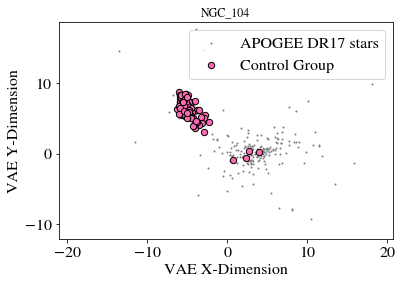

Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC
There are 287 stars in our sample after the proper motion filtering.
There are 287 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 287 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 287
38


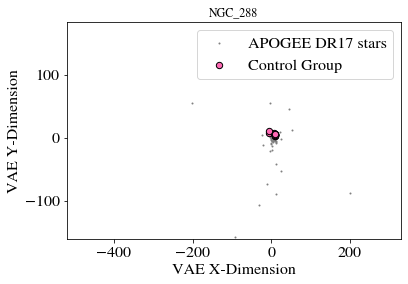

Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC
There are 1215 stars in our sample after the proper motion filtering.
There are 1215 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1215 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1215
38


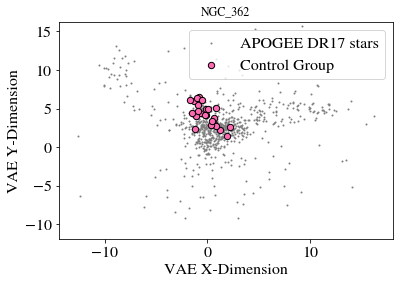

Done!


Processing: NGC_1851
311 stars in a 10x10 fov of the GC
There are 307 stars in our sample after the proper motion filtering.
There are 307 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 307 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 307
38


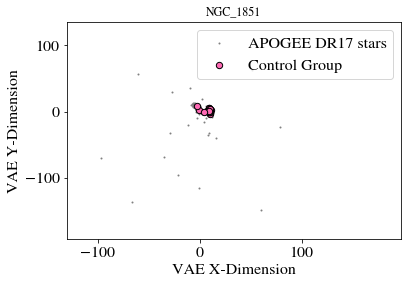

Done!


Processing: NGC_1904
248 stars in a 10x10 fov of the GC
There are 246 stars in our sample after the proper motion filtering.
There are 246 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 246 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 246
38


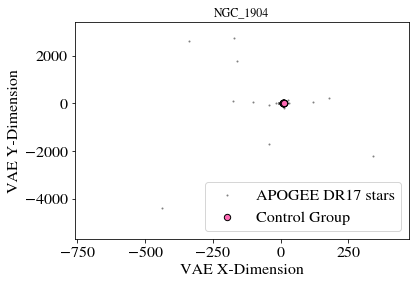

Done!


Processing: NGC_2808
566 stars in a 10x10 fov of the GC
There are 565 stars in our sample after the proper motion filtering.
There are 565 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 565 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 565
38


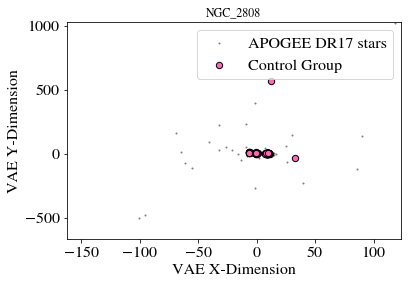

Done!


Processing: NGC_3201
1065 stars in a 10x10 fov of the GC
There are 1064 stars in our sample after the proper motion filtering.
There are 1064 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1064 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1064
38


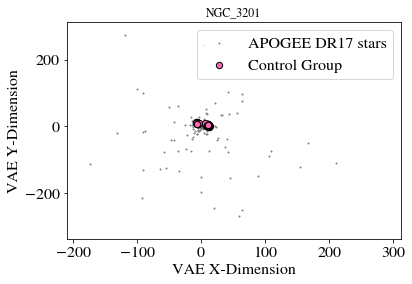

Done!


Processing: NGC_4590
310 stars in a 10x10 fov of the GC
There are 307 stars in our sample after the proper motion filtering.
There are 307 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 307 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 307
38


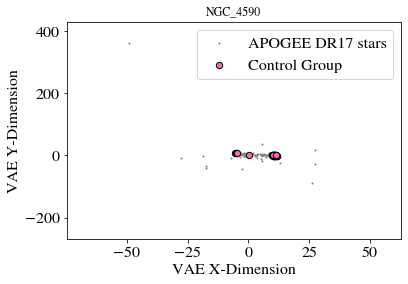

Done!


Processing: NGC_5024
592 stars in a 10x10 fov of the GC
There are 587 stars in our sample after the proper motion filtering.
There are 587 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 587 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 587
38


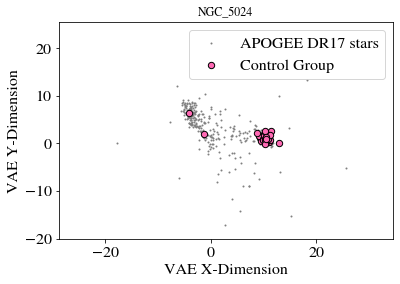

Done!


Processing: NGC_5139
1682 stars in a 10x10 fov of the GC
There are 1680 stars in our sample after the proper motion filtering.
There are 1680 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1680 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1680
38


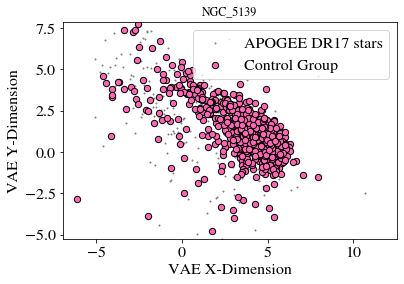

Done!


Processing: NGC_5272
1906 stars in a 10x10 fov of the GC
There are 1891 stars in our sample after the proper motion filtering.
There are 1891 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1891 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1891
38


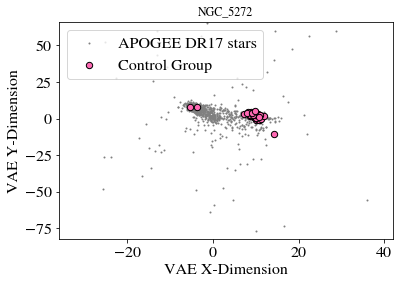

Done!


Processing: NGC_5904
927 stars in a 10x10 fov of the GC
There are 927 stars in our sample after the proper motion filtering.
There are 927 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 927 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 927
38


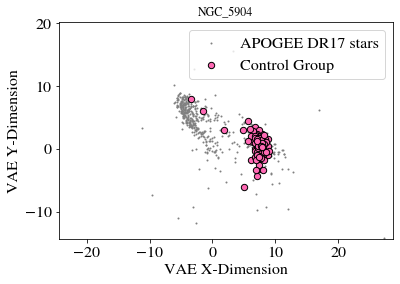

Done!


Processing: NGC_6121
3307 stars in a 10x10 fov of the GC
There are 3292 stars in our sample after the proper motion filtering.
There are 3292 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3292 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3292
38


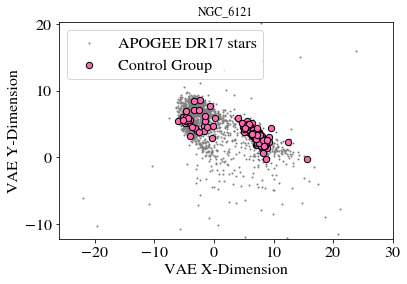

Done!


Processing: NGC_6171
733 stars in a 10x10 fov of the GC
There are 733 stars in our sample after the proper motion filtering.
There are 733 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 733 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 733
38


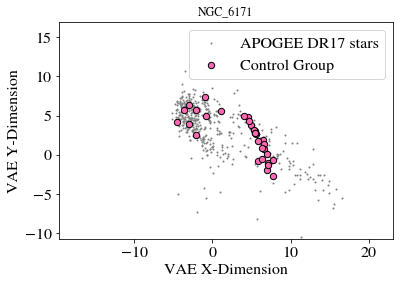

Done!


Processing: NGC_6205
2345 stars in a 10x10 fov of the GC
There are 2324 stars in our sample after the proper motion filtering.
There are 2324 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 2324 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 2324
38


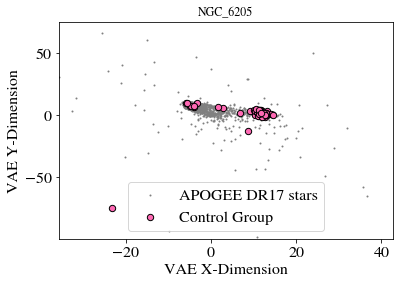

Done!


Processing: NGC_6218
986 stars in a 10x10 fov of the GC
There are 981 stars in our sample after the proper motion filtering.
There are 981 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 981 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 981
38


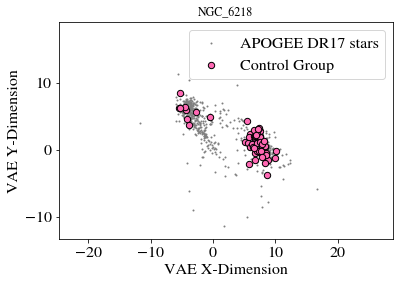

Done!


Processing: NGC_6254
815 stars in a 10x10 fov of the GC
There are 811 stars in our sample after the proper motion filtering.
There are 811 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 811 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 811
38


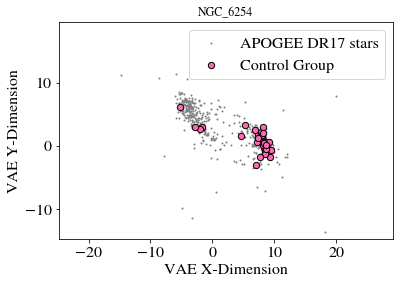

Done!


Processing: NGC_6273
3054 stars in a 10x10 fov of the GC
There are 3044 stars in our sample after the proper motion filtering.
There are 3044 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3044 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3044
38


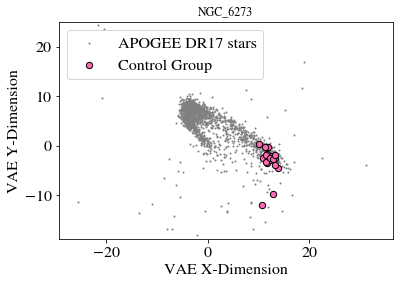

Done!


Processing: NGC_6341
536 stars in a 10x10 fov of the GC
There are 535 stars in our sample after the proper motion filtering.
There are 535 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 535 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 535
38


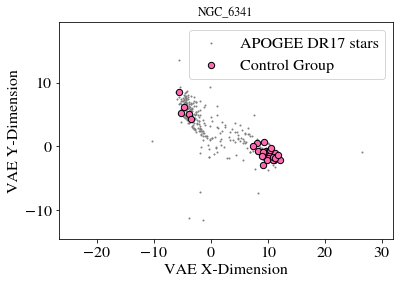

Done!


Processing: NGC_6380
899 stars in a 10x10 fov of the GC
There are 870 stars in our sample after the proper motion filtering.
There are 870 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 870 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 870
38


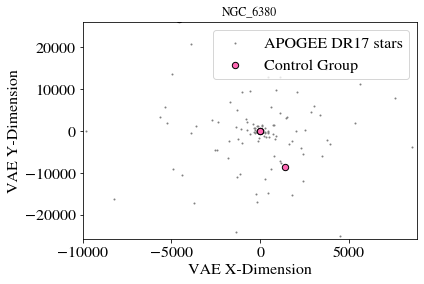

Done!


Processing: NGC_6388
424 stars in a 10x10 fov of the GC
There are 424 stars in our sample after the proper motion filtering.
There are 424 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 424 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 424
38


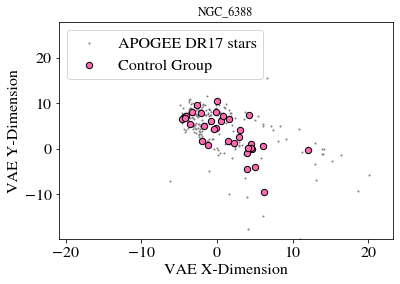

Done!


Processing: NGC_6397
1107 stars in a 10x10 fov of the GC
There are 1106 stars in our sample after the proper motion filtering.
There are 1106 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1106 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1106
38


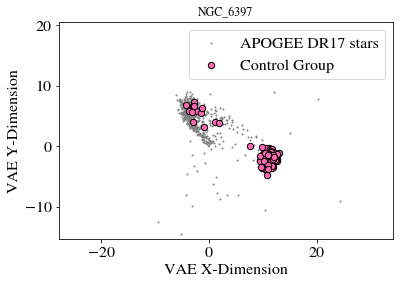

Done!


Processing: NGC_6441
1554 stars in a 10x10 fov of the GC
There are 1531 stars in our sample after the proper motion filtering.
There are 1531 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1531 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1531
38


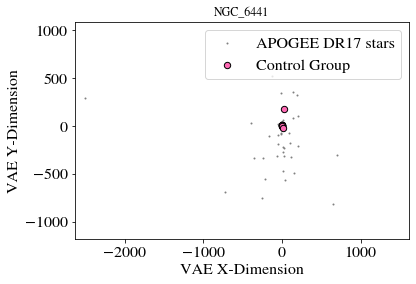

Done!


Processing: Ter_9
4085 stars in a 10x10 fov of the GC
There are 3983 stars in our sample after the proper motion filtering.
There are 3983 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3983 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3983
38


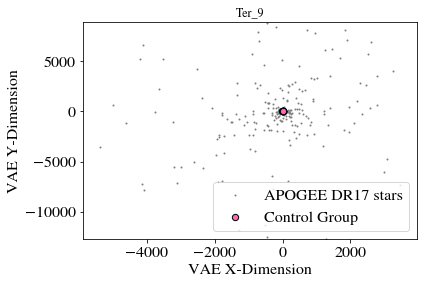

Done!


Processing: NGC_6522
3591 stars in a 10x10 fov of the GC
There are 3518 stars in our sample after the proper motion filtering.
There are 3518 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3518 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3518
38


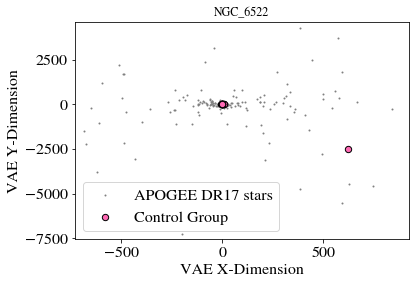

Done!


Processing: NGC_6544
3354 stars in a 10x10 fov of the GC
There are 3282 stars in our sample after the proper motion filtering.
There are 3282 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3282 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3282
38


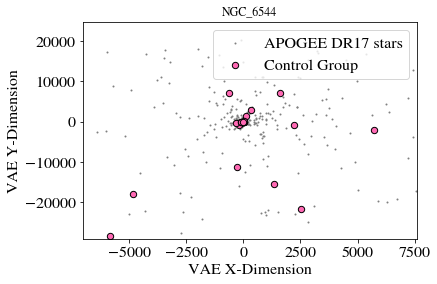

Done!


Processing: NGC_6553
3499 stars in a 10x10 fov of the GC
There are 3464 stars in our sample after the proper motion filtering.
There are 3464 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 3464 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 3464
38


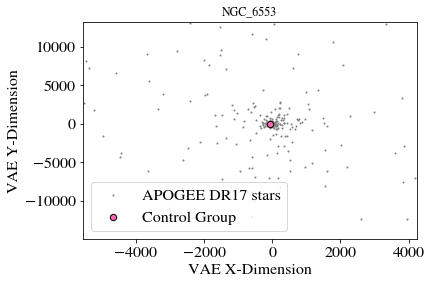

Done!


Processing: NGC_6656
2678 stars in a 10x10 fov of the GC
There are 2675 stars in our sample after the proper motion filtering.
There are 2675 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 2675 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 2675
38


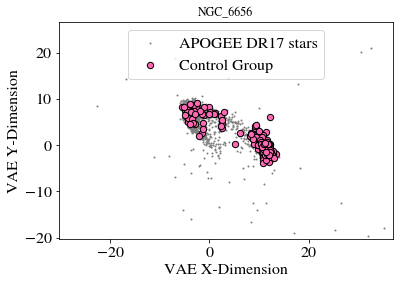

Done!


Processing: NGC_6715
2441 stars in a 10x10 fov of the GC
There are 2439 stars in our sample after the proper motion filtering.
There are 2439 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 2439 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 2439
38


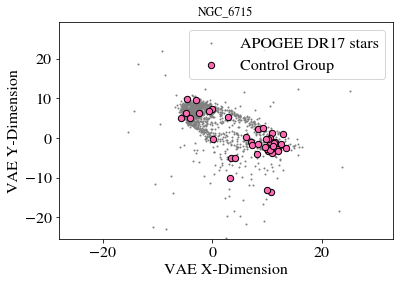

Done!


Processing: NGC_6752
230 stars in a 10x10 fov of the GC
There are 230 stars in our sample after the proper motion filtering.
There are 230 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 230 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 230
38


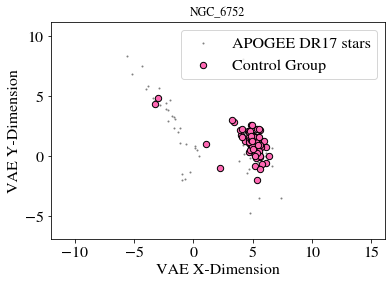

Done!


Processing: NGC_6809
861 stars in a 10x10 fov of the GC
There are 859 stars in our sample after the proper motion filtering.
There are 859 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 859 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 859
38


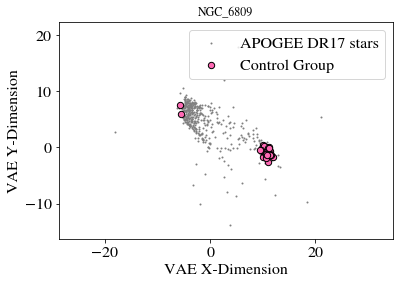

Done!


Processing: NGC_6838
2625 stars in a 10x10 fov of the GC
There are 2614 stars in our sample after the proper motion filtering.
There are 2614 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 2614 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 2614
38


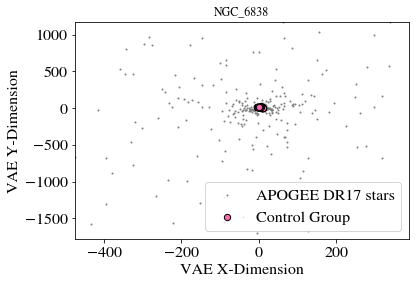

Done!


Processing: NGC_7078
1207 stars in a 10x10 fov of the GC
There are 1195 stars in our sample after the proper motion filtering.
There are 1195 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 1195 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 1195
38


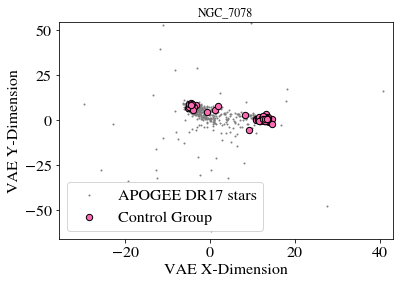

Done!


Processing: NGC_7089
785 stars in a 10x10 fov of the GC
There are 779 stars in our sample after the proper motion filtering.
There are 779 stars in our sample after the abundance filtering.
There were no duplicate spectra.
There are 779 stars in our sample after removing sources with low SNR.

The final amount of stars in our sample is: 779
38


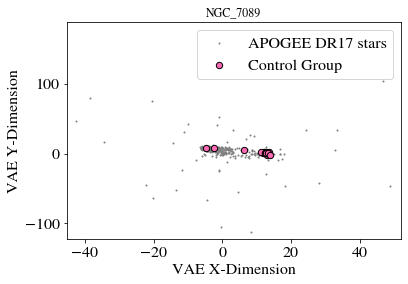

Done!


that shit took 11.834183764457702 mins


In [83]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_arr)):
    GC_stars_dict_norad[i] = master_func_nokin(i, all_param_dict_norad, fov, GC_db, apogee_nofilt, param_list, ML_index, tsne_ctrl_inds[count], umap_ctrl_inds[count], vae_ctrl_inds[count], encode, encode_weights, decode, decode_weights)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')

### break up into individual arrays

In [85]:
control_stars_list_norad = []
total_stars_list_norad = []

sum = 0
for key in GC_stars_dict_norad:
    #GC_name_list.append(key)
    if GC_stars_dict_norad[key][2] is None:
        control_stars_list_norad.append(0)
        total_stars_list_norad.append(0)
    else:
        sum += 1
        control_stars_list_norad.append(len(GC_stars_dict_norad[key][2]))
        total_stars_list_norad.append(len(GC_stars_dict_norad[key][0]))
    
#print(control_stars_list_norad)
#print(len(GC_name_list_norad))
print(sum)

34


In [86]:
new_control_stars_list_norad = []
new_total_stars_list_norad = []
new_stars_index_list_norad = []

for i in range(len(control_stars_list_norad)):
    #print(control_stars_list[i])
    new_control_stars_list_norad.append(control_stars_list_norad[i])
    new_total_stars_list_norad.append(total_stars_list_norad[i])
    new_stars_index_list_norad.append(i)
    '''if control_stars_list_norad[i] != 0:
        new_control_stars_list_norad.append(control_stars_list_norad[i])
        new_total_stars_list_norad.append(total_stars_list_norad[i])
        new_stars_index_list_norad.append(i)'''
        
print(len(new_stars_index_list_norad))

34


In [87]:
GC_name_arr_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

tsne_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

umap_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

vae_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
vae_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
vae_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
vae_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

tsne_control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
vae_control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)


for i in range(len(new_stars_index_list_norad)):
    ind = new_stars_index_list_norad[i]
    GC_name_arr_norad[i] = GC_name_list[ind]
    
    tsne_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][2]
    tsne_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][3]
    tsne_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][0]
    tsne_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][1]
    
    umap_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][6]
    umap_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][7]
    umap_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][4]
    umap_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][5]
    
    vae_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][10]
    vae_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][11]
    vae_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][8]
    vae_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][9]
    
    tsne_control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][12] # tsne control indices
    umap_control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][13] # umap control indices
    vae_control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][14] # vae control indices

In [88]:
### removing any outlier stars in vae field

vae_all_indices_norad_wo_outliers = np.empty(len(vae_control_indices_norad), dtype=list)
vae_outs_norad = np.empty(len(vae_control_indices_norad), dtype=list)
vae_ctrl_outs_norad = np.empty(len(vae_control_indices_norad), dtype=list)

for i in range(len(vae_control_indices_norad)):
    non_out = []
    out = []
    ctrl_out = []
    x_25, x_75 = np.percentile(vae_all_X_norad[i], [25,75])
    y_25, y_75 = np.percentile(vae_all_Y_norad[i], [25,75])
    
    iqr_x = x_75 - x_25
    iqr_y = y_75 - y_25
    
    min_x, max_x = x_25 - 1.5 * iqr_x, x_75 + 1.5 * iqr_x
    min_y, max_y = y_25 - 1.5 * iqr_y, y_75 + 1.5 * iqr_y
    
    for j in range(len(vae_all_X_norad[i])):
        #if vae_all_X_norad[i][j] < min_x or vae_all_X_norad[i][j] > max_x or vae_all_Y_norad[i][j] < min_y or vae_all_Y_norad[i][j] > max_y:
        if vae_all_X_norad[i][j] < -1e5 or vae_all_X_norad[i][j] > 1e5 or vae_all_Y_norad[i][j] < -1e5 or vae_all_Y_norad[i][j] > 1e5:
            if j in vae_control_indices_norad[i]:
                ctrl_out.append(j)
            out.append(j)
        else:
            non_out.append(j)
    
    vae_all_indices_norad_wo_outliers[i] = non_out
    vae_outs_norad[i] = out
    vae_ctrl_outs_norad[i] = ctrl_out

#print(vae_all_indices_norad_wo_outliers[0])
#print(vae_outs_norad[0])

In [89]:
### correcting vae control star indices after removing outliers

vae_all_X_norad_wo_outs = np.empty(len(vae_all_X_norad), dtype=list)
vae_all_Y_norad_wo_outs = np.empty(len(vae_all_Y_norad), dtype=list)
vae_control_indices_norad_wo_outs = np.empty(len(vae_control_indices_norad), dtype=np.ndarray)

for i in range(len(vae_all_indices_norad_wo_outliers)):
    temp_ctrl = []
    vae_all_X_norad_wo_outs[i] = vae_all_X_norad[i][vae_all_indices_norad_wo_outliers[i]]
    vae_all_Y_norad_wo_outs[i] = vae_all_Y_norad[i][vae_all_indices_norad_wo_outliers[i]]
    
    if len(vae_outs_norad[i]) == 0:
        temp_ctrl = [k for k in vae_control_indices_norad[i]]
    else:
        for ctrl_index, ctrl_value in enumerate(vae_control_indices_norad[i]):
            temp_value = ctrl_value
            for removed_index, removed_value in enumerate(vae_outs_norad[i]):
                if ctrl_value > removed_value:
                    temp_value -= 1
            temp_ctrl.append(temp_value)
        
    vae_control_indices_norad_wo_outs[i] = np.array(temp_ctrl)


vae_control_X_norad_wo_outs = np.empty(len(vae_control_indices_norad_wo_outs), dtype=np.ndarray)
vae_control_Y_norad_wo_outs = np.empty(len(vae_control_indices_norad_wo_outs), dtype=np.ndarray)
for count, i in enumerate(vae_control_indices_norad_wo_outs):
    vae_control_X_norad_wo_outs[count] = vae_all_X_norad_wo_outs[count][i]
    vae_control_Y_norad_wo_outs[count] = vae_all_Y_norad_wo_outs[count][i]

## dbscan for all stars

In [105]:
def plot_ML_norad(name, pack, ML):
    ### function that plots the tsne and umap of the GC again
    ### tsne = [ctrlX, ctrlY, allX, allY], same for umap
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.scatter(pack[2], pack[3], s=1, c='gray', label='APOGEE DR17 stars') # all
    ax.scatter(pack[0], pack[1], s=40, edgecolor='k', c='hotpink', label='Control Group') # ctrl
    ax.set_title(name + ML, fontsize=30)
    ax.set_xlabel(ML + " X-Dimension", fontsize=16)
    ax.set_ylabel(ML + " Y-Dimension", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.savefig('GCs_20RHMRT_6/' + name + '/' + ML + '_norad.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

In [106]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    try:
        ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    except:
        ball = tree.query_ball_tree(tree, percentile_95, p = 2)
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_6/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
    

    
    max_group_label = []
    max_group_count = []

    for ind, labels in enumerate(labels_lst):
        # get unique
        lab, cow = np.unique(labels, return_counts=True)

        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        
        ctrl_lab, ctrl_cow = np.unique(control_labels, return_counts=True)
        #print(ctrl_lab, ctrl_cow)
        
        max_count_index = cow.argmax()
        
        max_ctrl_count_index = ctrl_cow.argmax()
        #print('Max count: ', ctrl_cow[max_ctrl_count_index], '\tMax lab: ', ctrl_lab[max_ctrl_count_index])
        
        if ctrl_lab[max_ctrl_count_index] == -1:
            max_group_count.append(0)
        elif ctrl_lab[max_ctrl_count_index] == lab[max_count_index]:
            if cow[max_count_index] >= 0.95 * len(x): # cutting out anythat are 95% of the entire field
                max_group_count.append(0)
            else:
                max_group_count.append(ctrl_cow[max_ctrl_count_index])
                
        else:
            max_group_count.append(ctrl_cow[max_ctrl_count_index])
        
        max_group_label.append(ctrl_lab[max_ctrl_count_index])
        
        
        '''if len(control_labels) == 0:
            max_lab = -1
            max_pos = 0
        else:
            max_lab = st.mode(control_labels)[0][0] # find the most common label
            max_pos = np.where(lab == max_lab)[0][0] # find the index of that common label for control stars
        # returning the group label, number of members for largest control star group
        if max_lab == -1: # if the majority of control stars are in the noise
            max_group_label.append(lab[max_pos])
            max_group_count.append(0)
        else:
            max_group_label.append(lab[max_pos])
            max_group_count.append(cow[max_pos])'''
    
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_count):
        '''if item >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
            item = 0'''
        max_group_count_arr[ind%10][ind//10] = item
    
    
    ### DBSCAN matrix
    '''# all
    fig, ax = plt.subplots(10, 10, figsize=(100,100))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            #ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric score: ' + str(max_group_count[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_6/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_6/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)'''
    
    # indices for the max section of heat map
    max_heatmap_col, max_heatmap_row = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape)
    
    return [eps_arr[max_heatmap_col], neigh_arr[max_heatmap_row]]

In [92]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_3/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
    

    
    '''max_group_label = []
    max_group_count = []

    for ind, labels in enumerate(labels_lst):
        # get unique
        lab, cow = np.unique(labels, return_counts=True)

        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        
        ctrl_lab, ctrl_cow = np.unique(control_labels, return_counts=True)
        print(ctrl_lab, ctrl_cow)
        
        max_count_index = cow.argmax()
        
        max_ctrl_count_index = ctrl_cow.argmax()
        print('Max count: ', ctrl_cow[max_ctrl_count_index], '\tMax lab: ', ctrl_lab[max_ctrl_count_index])
        
        if ctrl_lab[max_ctrl_count_index] == -1:
            max_group_count.append(0)
        elif ctrl_lab[max_ctrl_count_index] == lab[max_count_index]:
            if cow[max_count_index] >= 0.95 * len(x): # cutting out anythat are 95% of the entire field
                max_group_count.append(0)
            else:
                max_group_count.append(ctrl_cow[max_ctrl_count_index])
                
        else:
            max_group_count.append(ctrl_cow[max_ctrl_count_index])
        
        max_group_label.append(ctrl_lab[max_ctrl_count_index])'''
    
    max_group_label = []
    max_group_metric = []
    N_sigma2 = []

    for ind, counts in enumerate(labels_lst): # going through every DBSCAN
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)
        
        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        ctrl_lab, ctrl_cow_temp = np.unique(control_labels, return_counts=True)
        '''max_count_index = cow.argmax()
        max_ctrl_count_index = ctrl_cow.argmax()'''
        
        ctrl_cow = np.zeros(len(lab))
        for i in range(len(ctrl_lab)):
            if ctrl_lab[i] in lab:
                for j in range(len(lab)):
                    if lab[j] == ctrl_lab[i]:
                        ctrl_cow[j] = ctrl_cow_temp[i]
                        
        #print('field lab: ', lab, '\tctrl lab: ', ctrl_lab, '\tctrl count: ', ctrl_cow, '\tTotal ctrl: ', len(control_indices))
        
        sigma_label = []
        median_label = []
        for i in range(len(lab)): # for each group label
            lab_indices = [] # indices list for those that belong to the group
            for j in range(len(counts)): # go through all the stars and add the ones that have that label to the label indices
                if counts[j] == lab[i]:
                    lab_indices.append(j)
            
            # ckdtree for each label
            col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
            tree_label = cKDTree(col_label) # making a tree
            dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
            dist_median = np.median(dist_label[:,1])
            dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
            
            sigma_label.append(dist_sigma)
            median_label.append(dist_median)
        
        N_sigma2 = [] # N / sigma^2 list
        
        for i in range(len(cow)):
            if int(ctrl_cow[i]) == len(control_indices):
                #print(ctrl_cow[i] / sigma_label[i]**2)
                if cow[i] >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
                    #print('too big')
                    N_sigma2.append(0)
                elif math.isinf(ctrl_cow[i] / sigma_label[i]**2) or math.isnan(ctrl_cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                    N_sigma2.append(0)
                else:
                    N_sigma2.append(ctrl_cow[i] / sigma_label[i]**2) # calculating total control members / dispersion of group
            else:
                N_sigma2.append(0)

        max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
        #print(N_sigma2, max_pos)
        
        # returning the for group with highest metric
        if lab[max_pos] == -1:
            max_group_metric.append(0)
        else:
            max_group_metric.append(N_sigma2[max_pos])
        
        '''# group label with highest metric
        max_group_label.append(lab[max_pos])'''
        
   
    #print('final metrics: ', N_sigma2)
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_count_arr[ind%10][ind//10] = item
    
    
    ### DBSCAN matrix
    # all
    fig, ax = plt.subplots(10, 10, figsize=(100,100))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            #ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric score: ' + str(max_group_metric[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_3/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_3/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_heatmap_col, max_heatmap_row = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape)
    
    return [eps_arr[max_heatmap_col], neigh_arr[max_heatmap_row]]

In [112]:
def db_opt(name, title, x, y, eps, samp, control_indices):
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    ### in theory the DBSCAN step above should have only chosen iterations that have all the control stars in 1 group,
    ### so just finding that group should be sufficient
    et_ind = []
    
    # get unique
    lab, cow = np.unique(labels, return_counts=True)

    # getting index of most control members
    control_labels = labels[control_indices] # labels of the control stars
    
    #print(control_labels)
    
    if len(control_labels) == 0:
        max_lab = 10000
    else:
        max_lab = st.mode(control_labels)[0][0] # find the most common label
    
    #print(max_lab)
    
    for ind, labs in enumerate(labels):
        if labs == max_lab:
            et_ind.append(ind)
            
    print('Number of stars in the chosen field cluster is: ' + str(len(et_ind)) + ' for ' + title)
    
    
    
    '''# all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=40)
    ax.set_ylabel('Y', fontsize=40)
    ax.legend(fontsize=10)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_lab), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_6/' + name + '/' + title + '_dbscan.png'
    plt.savefig(file_name)
    #plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)'''
    
    return et_ind

### Now we need to match control stars to the right group

In [108]:
def plot_shit_and_rt_filter(name, n, final_unfilt):
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2
    
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rhm = GC_db['rhm'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rhm_deg = math.degrees(math.atan(M3_rhm / M3_d_Sun))
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    M3_stars = []
    for count, i in enumerate(apogee_nofilt['RA'].values):
        if i >= M3_ra - M3_fov and i <= M3_ra + M3_fov and apogee_nofilt['DEC'].values[count] >= M3_dec - M3_fov and apogee_nofilt['DEC'].values[count] <= M3_dec + M3_fov:
            M3_stars.append(apogee_nofilt.loc[count])

    #print(len(M3_stars), 'stars in a 10x10 fov of the GC')
    
    ### grabbing final field stars
    M3_ra_arr = np.empty(len(M3_stars), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars), dtype=float)
    for count, i in enumerate(M3_stars):
        M3_ra_arr[count] = i['RA']
        M3_dec_arr[count] = i['DEC']
        
    ### filtering out et stars that are outside of the rt
    in_rt = in_circle(M3_ra, M3_dec, M3_rt_deg, M3_ra_arr[final_unfilt], M3_dec_arr[final_unfilt])
    final_et = np.array(final_unfilt)[np.where(in_rt == False)[0]]

    
    M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    '''fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='red', marker='x', linestyle='none', markersize=5, label='GC centre')
    #ax.plot(M3_ra_arr[controls], M3_dec_arr[controls], color='cyan', linestyle='none', marker='o', ms=5, label='Original controls')
    ax.plot(M3_ra_arr[final_et], M3_dec_arr[final_et], color='fuchsia', linestyle='none', marker='*', ms=5, label='ET Candidates')
    ax.add_patch(M3_rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('DEC', fontsize=20)
    ax.set_title('Final stars for ' + GC_name_arr[n] + '\tCandidates: ' + str(len(final_et)), fontsize=20)
    ax.set_xlim(M3_ra - M3_fov - 1, M3_ra + M3_fov + 1)
    ax.set_ylim(M3_dec - M3_fov - 1, M3_dec + M3_fov + 1)
    ax.legend(loc='best', fontsize=20)
    plt.savefig('GCs_20RHMRT_6/' + name + '/et_stars.png')
    plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)'''
    
    return final_et


In [109]:
def final_et_stars(control_indices_tsne, control_indices_umap, control_indices_vae, tsne_et_ind, umap_et_ind, vae_et_ind):
    final_tsne = []
    final_umap = []
    final_vae = []
    final_et = []
    
    
    for i in tsne_et_ind:
        if i not in control_indices_tsne:
            final_tsne.append(i)
            
    for i in umap_et_ind:
        if i not in control_indices_umap:
            final_umap.append(i)
            
    for i in vae_et_ind:
        if i not in control_indices_vae:
            final_vae.append(i)
            
    for i in final_tsne:
        if i in final_umap and i in final_vae:
            final_et.append(i)
            
    return [final_et, final_tsne, final_umap, final_vae]

## special test: using N for group size rather than N for control stars, after all control stars have been captured

In [46]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    #plt.savefig('GCs_20RHMRT_4/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
    

    
    '''max_group_label = []
    max_group_count = []

    for ind, labels in enumerate(labels_lst):
        # get unique
        lab, cow = np.unique(labels, return_counts=True)

        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        
        ctrl_lab, ctrl_cow = np.unique(control_labels, return_counts=True)
        print(ctrl_lab, ctrl_cow)
        
        max_count_index = cow.argmax()
        
        max_ctrl_count_index = ctrl_cow.argmax()
        print('Max count: ', ctrl_cow[max_ctrl_count_index], '\tMax lab: ', ctrl_lab[max_ctrl_count_index])
        
        if ctrl_lab[max_ctrl_count_index] == -1:
            max_group_count.append(0)
        elif ctrl_lab[max_ctrl_count_index] == lab[max_count_index]:
            if cow[max_count_index] >= 0.95 * len(x): # cutting out anythat are 95% of the entire field
                max_group_count.append(0)
            else:
                max_group_count.append(ctrl_cow[max_ctrl_count_index])
                
        else:
            max_group_count.append(ctrl_cow[max_ctrl_count_index])
        
        max_group_label.append(ctrl_lab[max_ctrl_count_index])'''
    
    max_group_label = []
    max_group_metric = []
    N_sigma2 = []

    for ind, counts in enumerate(labels_lst): # going through every DBSCAN
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)
        
        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        ctrl_lab, ctrl_cow_temp = np.unique(control_labels, return_counts=True)
        '''max_count_index = cow.argmax()
        max_ctrl_count_index = ctrl_cow.argmax()'''
        
        ctrl_cow = np.zeros(len(lab))
        for i in range(len(ctrl_lab)):
            if ctrl_lab[i] in lab:
                for j in range(len(lab)):
                    if lab[j] == ctrl_lab[i]:
                        ctrl_cow[j] = ctrl_cow_temp[i]
                        
        #print('field lab: ', lab, '\tctrl lab: ', ctrl_lab, '\tctrl count: ', ctrl_cow)
        
        sigma_label = []
        median_label = []
        for i in range(len(lab)): # for each group label
            lab_indices = [] # indices list for those that belong to the group
            for j in range(len(counts)): # go through all the stars and add the ones that have that label to the label indices
                if counts[j] == lab[i]:
                    lab_indices.append(j)
            
            # ckdtree for each label
            col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
            tree_label = cKDTree(col_label) # making a tree
            dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
            dist_median = np.median(dist_label[:,1])
            dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
            
            sigma_label.append(dist_sigma)
            median_label.append(dist_median)
        
        N_sigma2 = [] # N / sigma^2 list
        
        for i in range(len(cow)):
            if int(ctrl_cow[i]) == len(control_indices):
                if cow[i] >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
                    N_sigma2.append(0)
                elif math.isinf(cow[i] / sigma_label[i]**2) or math.isnan(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                    N_sigma2.append(0)
                else:
                    N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total control members / dispersion of group
            else:
                N_sigma2.append(0)

        max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
        #print(N_sigma2, max_pos)
        
        # returning the for group with highest metric
        if lab[max_pos] == -1:
            max_group_metric.append(0)
        else:
            max_group_metric.append(N_sigma2[max_pos])
        
        '''# group label with highest metric
        max_group_label.append(lab[max_pos])'''
        
   
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_count_arr[ind%10][ind//10] = item
    
    
    ### DBSCAN matrix
    # all
    fig, ax = plt.subplots(10, 10, figsize=(100,100))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            #ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric score: ' + str(max_group_metric[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_4/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_4/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_heatmap_col, max_heatmap_row = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape)
    
    return [eps_arr[max_heatmap_col], neigh_arr[max_heatmap_row]]

In [54]:
def db_opt(name, title, x, y, eps, samp, control_indices):
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    
    
    '''# get unique
    lab, cow = np.unique(labels, return_counts=True)

    # getting index of most control members
    control_labels = labels[control_indices] # labels of the control stars
    
    #print(control_labels)
    
    if len(control_labels) == 0:
        max_lab = 10000
    else:
        max_lab = st.mode(control_labels)[0][0] # find the most common label
    
    #print(max_lab)
    
    for ind, labs in enumerate(labels):
        if labs == max_lab:
            et_ind.append(ind)'''
    
    et_ind = []
    N_sigma2 = []

    lab, cow = np.unique(labels, return_counts=True)

    # getting index of most control members
    control_labels = labels[control_indices] # labels of the control stars
    ctrl_lab, ctrl_cow_temp = np.unique(control_labels, return_counts=True)

    ctrl_cow = np.zeros(len(lab))
    for i in range(len(ctrl_lab)):
        if ctrl_lab[i] in lab:
            for j in range(len(lab)):
                if lab[j] == ctrl_lab[i]:
                    ctrl_cow[j] = ctrl_cow_temp[i]

    #print('field lab: ', lab, '\tctrl lab: ', ctrl_lab, '\tctrl count: ', ctrl_cow)

    sigma_label = []
    median_label = []
    for i in range(len(lab)): # for each group label
        lab_indices = [] # indices list for those that belong to the group
        for j in range(len(labels)): # go through all the stars and add the ones that have that label to the label indices
            if labels[j] == lab[i]:
                lab_indices.append(j)

        # ckdtree for each label
        col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
        tree_label = cKDTree(col_label) # making a tree
        dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
        dist_median = np.median(dist_label[:,1])
        dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion

        sigma_label.append(dist_sigma)
        median_label.append(dist_median)

    N_sigma2 = [] # N / sigma^2 list

    for i in range(len(cow)):
        if int(ctrl_cow[i]) == len(control_indices):
            if cow[i] >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
                N_sigma2.append(0)
            elif math.isinf(cow[i] / sigma_label[i]**2) or math.isnan(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                N_sigma2.append(0)
            else:
                N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total control members / dispersion of group
        else:
            N_sigma2.append(0)

    max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
    #print(N_sigma2, max_pos, lab)

    for index, label in enumerate(labels):
        if label == lab[max_pos]:
            et_ind.append(index)
            
    temp_lab = np.copy(lab)
    
    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=40)
    ax.set_ylabel('Y', fontsize=40)
    ax.legend(fontsize=10)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(temp_lab[max_pos]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_4/' + name + '/' + title + '_dbscan.png'
    plt.savefig(file_name)
    #plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    return et_ind

In [98]:
final_et_arr = []
final_tsne = []
final_umap = []
final_vae = []

In [283]:
for i in tqdm(range(0,34)):
    vae_pack = [vae_control_X_norad[i], vae_control_Y_norad[i], vae_all_X_norad[i], vae_all_Y_norad[i]]
    plot_ML_norad(GC_name_arr[i], vae_pack, 'vae2')

In [352]:
for i in tqdm(range(0,34)):
    try:
        os.makedirs('GCs_20RHMRT_6/' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X_norad[i], tsne_control_Y_norad[i], tsne_all_X_norad[i], tsne_all_Y_norad[i]]
    umap_pack = [umap_control_X_norad[i], umap_control_Y_norad[i], umap_all_X_norad[i], umap_all_Y_norad[i]]
    vae_pack = [vae_control_X_norad_wo_outs[i], vae_control_Y_norad_wo_outs[i], vae_all_X_norad_wo_outs[i], vae_all_Y_norad_wo_outs[i]]
    
    plot_ML_norad(GC_name_arr[i], tsne_pack, 'tsne')
    plot_ML_norad(GC_name_arr[i], umap_pack, 'umap')
    plot_ML_norad(GC_name_arr[i], vae_pack, 'vae')

Directory NGC_104 already exists
Directory NGC_288 already exists
Directory NGC_362 already exists
Directory NGC_1851 already exists
Directory NGC_1904 already exists
Directory NGC_2808 already exists
Directory NGC_3201 already exists
Directory NGC_4590 already exists
Directory NGC_5024 already exists
Directory NGC_5139 already exists
Directory NGC_5272 already exists
Directory NGC_5904 already exists
Directory NGC_6121 already exists
Directory NGC_6171 already exists
Directory NGC_6205 already exists
Directory NGC_6218 already exists
Directory NGC_6254 already exists
Directory NGC_6273 already exists
Directory NGC_6341 already exists
Directory NGC_6380 already exists
Directory NGC_6388 already exists
Directory NGC_6397 already exists
Directory NGC_6441 already exists
Directory Ter_9 already exists
Directory NGC_6522 already exists
Directory NGC_6544 already exists
Directory NGC_6553 already exists
Directory NGC_6656 already exists
Directory NGC_6715 already exists
Directory NGC_6752 a

In [116]:
final_et_arr = []
final_tsne = []
final_umap = []
final_vae = []

In [117]:
start = time.time()

for i in tqdm(range(0,34)):
    try:
        os.makedirs('GCs_20RHMRT_6/' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X_norad[i], tsne_control_Y_norad[i], tsne_all_X_norad[i], tsne_all_Y_norad[i]]
    umap_pack = [umap_control_X_norad[i], umap_control_Y_norad[i], umap_all_X_norad[i], umap_all_Y_norad[i]]
    vae_pack = [vae_control_X_norad_wo_outs[i], vae_control_Y_norad_wo_outs[i], vae_all_X_norad_wo_outs[i], vae_all_Y_norad_wo_outs[i]]
    
    plot_ML_norad(GC_name_arr[i], tsne_pack, 'tsne')
    plot_ML_norad(GC_name_arr[i], umap_pack, 'umap')
    plot_ML_norad(GC_name_arr[i], vae_pack, 'vae')

    tsne_eps_all, tsne_samp_all = db(GC_name_arr[i], 'tsne', tsne_all_X_norad[i], tsne_all_Y_norad[i], tsne_ctrl_inds[i])
    umap_eps_all, umap_samp_all = db(GC_name_arr[i], 'umap', umap_all_X_norad[i], umap_all_Y_norad[i], umap_ctrl_inds[i])
    vae_eps_all, vae_samp_all = db(GC_name_arr[i], 'vae', vae_all_X_norad_wo_outs[i], vae_all_Y_norad_wo_outs[i], vae_control_indices_norad_wo_outs[i])
    
    
    tsne_et = db_opt(GC_name_arr[i], 'tsne', tsne_all_X_norad[i], tsne_all_Y_norad[i], tsne_eps_all, tsne_samp_all, tsne_ctrl_inds[i])
    umap_et = db_opt(GC_name_arr[i], 'umap', umap_all_X_norad[i], umap_all_Y_norad[i], umap_eps_all, umap_samp_all, umap_ctrl_inds[i])
    vae_et = db_opt(GC_name_arr[i], 'vae', vae_all_X_norad_wo_outs[i], vae_all_Y_norad_wo_outs[i], vae_eps_all, vae_samp_all, vae_control_indices_norad_wo_outs[i])

    
    temp_var = final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], vae_control_indices_norad_wo_outs[i], tsne_et, umap_et, vae_et)[0]
    
    final_tsne.append(final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], vae_control_indices_norad_wo_outs[i], tsne_et, umap_et, vae_et)[1])
    final_umap.append(final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], vae_control_indices_norad_wo_outs[i], tsne_et, umap_et, vae_et)[2])
    final_vae.append(final_et_stars(tsne_ctrl_inds[i], umap_ctrl_inds[i], vae_control_indices_norad_wo_outs[i], tsne_et, umap_et, vae_et)[3])
    
    ### Table making
    print('Number of non-control tSNE stars: ' + str(len(final_tsne[i])))
    print('Number of non-control UMAP stars: ' + str(len(final_umap[i])))
    print('Number of non-control VAE stars: ' + str(len(final_vae[i])))
    print('Number of non-control ET stars: ' + str(len(temp_var)))
    
    if len(temp_var) == 0:
        print('Nothing to plot, you got no controls yo\n')
        final_et_arr.append([])
    else:
        final_et_arr.append(plot_shit_and_rt_filter(GC_name_arr[i], i, temp_var))
        print('Final ET: ' + str(len(final_et_arr[i])))
        print('Final ET tSNE: ' + str(len(plot_shit_and_rt_filter(GC_name_arr[i], i, final_tsne[i]))))
        print('Final ET UMAP: ' + str(len(plot_shit_and_rt_filter(GC_name_arr[i], i, final_umap[i]))))
        print('Final ET VAE: ' + str(len(plot_shit_and_rt_filter(GC_name_arr[i], i, final_vae[i]))))
        print('\n')
        
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()
'''play_obj.wait_done()
play_obj.stop()'''

Directory NGC_104 already exists
Number of stars in the chosen field cluster is: 154 for tsne
Number of stars in the chosen field cluster is: 156 for umap
Number of stars in the chosen field cluster is: 357 for vae
Number of non-control tSNE stars: 96
Number of non-control UMAP stars: 37
Number of non-control VAE stars: 267
Number of non-control ET stars: 20
Final ET: 13
Final ET tSNE: 24
Final ET UMAP: 25
Final ET VAE: 174


Directory NGC_288 already exists
Number of stars in the chosen field cluster is: 33 for tsne
Number of stars in the chosen field cluster is: 35 for umap
Number of stars in the chosen field cluster is: 159 for vae
Number of non-control tSNE stars: 13
Number of non-control UMAP stars: 22
Number of non-control VAE stars: 139
Number of non-control ET stars: 3
Final ET: 2
Final ET tSNE: 6
Final ET UMAP: 11
Final ET VAE: 85


Directory NGC_362 already exists
Number of stars in the chosen field cluster is: 571 for tsne
Number of stars in the chosen field cluster is: 496 

Final ET: 273
Final ET tSNE: 487
Final ET UMAP: 517
Final ET VAE: 432


Directory NGC_6388 already exists
Number of stars in the chosen field cluster is: 17 for tsne
Number of stars in the chosen field cluster is: 17 for umap
Number of stars in the chosen field cluster is: 253 for vae
Number of non-control tSNE stars: 0
Number of non-control UMAP stars: 0
Number of non-control VAE stars: 211
Number of non-control ET stars: 0
Nothing to plot, you got no controls yo
Directory NGC_6397 already exists
Number of stars in the chosen field cluster is: 134 for tsne
Number of stars in the chosen field cluster is: 135 for umap
Number of stars in the chosen field cluster is: 698 for vae
Number of non-control tSNE stars: 21
Number of non-control UMAP stars: 14
Number of non-control VAE stars: 590
Number of non-control ET stars: 7
Final ET: 6
Final ET tSNE: 11
Final ET UMAP: 12
Final ET VAE: 434


Directory NGC_6441 already exists
Number of stars in the chosen field cluster is: 769 for tsne
Number 

'play_obj.wait_done()\nplay_obj.stop()'

<Figure size 432x288 with 0 Axes>

In [259]:
play_obj.stop()